In [93]:
!pip install catboost

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys; sys.path.insert(0, '..')
import torch


from CatBoostModel import CatBoost_model
from metrics import root_mean_squared_error, mean_absolute_percentage_error
from preprocessor import Preprocessor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor


sns.set(font_scale=1.5)
%matplotlib inline

In [95]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == torch.device('cpu'):
    print('Using cpu')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name(0)))

Using Tesla T4 GPUs


In [96]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
DATA_PATH = "/content/drive/My Drive/HobbyTaste/data/nasdaq100_padding.csv"
dim_size=3

In [0]:
df = pd.read_csv(DATA_PATH)

In [99]:
preproc = Preprocessor(
    dataset=df.iloc[:40000, :].values,
    dim_size=dim_size
)
preproc.scale()
preproc.train_test_split(
    train_size=35000,
    use_tqdm=True,
)

In [0]:
cbr = CatBoost_model(
    use_gpu=False,
    loss_function='MultiRMSE',
    multi_target=True,
    params={'iterations':1000,},
    device=device
)

In [101]:
cbr.train_multi(
    x_train=preproc.get_data(
        name='x_train',
        torch_tensor=False,
    ),
    y_train=preproc.get_data(
        name='y_train',
        torch_tensor=False,
    ),
    train_horizon=30,
)

0:	learn: 0.0014340	total: 95.9ms	remaining: 1m 35s
100:	learn: 0.0014070	total: 8.27s	remaining: 1m 13s
200:	learn: 0.0013809	total: 16.4s	remaining: 1m 5s
300:	learn: 0.0013597	total: 24.5s	remaining: 56.8s
400:	learn: 0.0013385	total: 32.4s	remaining: 48.4s
500:	learn: 0.0013171	total: 40.4s	remaining: 40.2s
600:	learn: 0.0012974	total: 48.3s	remaining: 32.1s
700:	learn: 0.0012780	total: 56.2s	remaining: 24s
800:	learn: 0.0012621	total: 1m 4s	remaining: 15.9s
900:	learn: 0.0012461	total: 1m 12s	remaining: 7.92s
999:	learn: 0.0012314	total: 1m 19s	remaining: 0us


Попробуем сделать предсказания для `pred_horizon = 3`

In [102]:
cbr.pred_multi(preproc.get_data(name='x_test', torch_tensor=False), 
                    horizon_pred_out=3)

array([[[-2.24436959e-05,  6.28074233e-06,  2.85889971e-05],
        [-7.97690777e-06, -7.25598396e-05,  9.36141923e-05],
        [-7.91453068e-05, -2.36920097e-05, -1.25261410e-05]],

       [[-5.68552159e-05, -2.07569964e-05, -5.50640661e-06],
        [ 4.16126714e-06, -1.75798906e-06, -4.74443241e-05],
        [ 4.89334360e-05,  1.66305821e-05, -2.81489374e-05]],

       [[-2.11697757e-05,  1.60234625e-05,  5.33561967e-06],
        [ 1.89361816e-05,  2.54984289e-06,  1.37013003e-05],
        [ 2.54813881e-06,  2.12979655e-05,  1.53436580e-05]],

       ...,

       [[-9.28779618e-06,  5.55735179e-06,  1.89537466e-06],
        [ 1.31076077e-05,  8.99696908e-06, -4.44090611e-06],
        [ 5.48165183e-08,  1.62897781e-05,  3.03248562e-06]],

       [[-9.96768147e-06,  1.12782950e-05,  9.70779406e-07],
        [-3.05094576e-05, -1.28813237e-05, -9.56257824e-06],
        [-6.90681463e-06,  9.79745663e-06,  1.15030930e-05]],

       [[-6.17825518e-06, -1.80050090e-05,  1.19273058e-06],
 

Построим графики предсказаний.

In [0]:
pred = cbr.pred_multi(preproc.get_data(name='x_test', torch_tensor=False), 
                      horizon_pred_out=1)

In [0]:
test = preproc.get_data(name='y_test',torch_tensor=False)[:, :1, :]

In [0]:
final_res = np.concatenate(
    ([preproc.raw_dataset[4000, ]],
    pred)
).cumsum(axis=0)

In [0]:
final_test = np.concatenate(
    ([preproc.raw_dataset[4000, ]],
     test.reshape(len(test), -1))
).cumsum(axis=0)

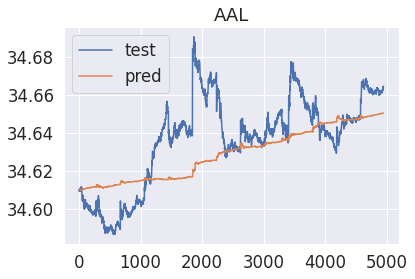

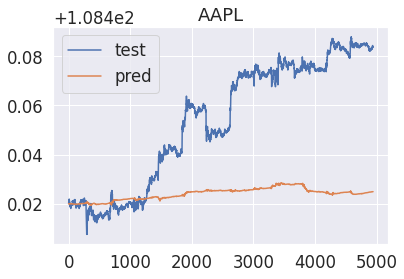

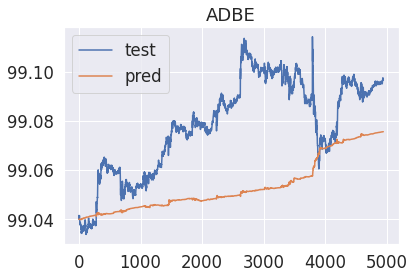

In [107]:
for i in np.arange(3):
    plt.title(df.columns[i])
    plt.plot(final_test[:, i], label='test')
    plt.plot(final_res[:, i], label='pred')
    plt.legend()
    plt.show()

Попробуем теперь XGBoost без подбора параметров, используя класс `MultiOutputRegressor` для multi-regression.

In [0]:
xgb_multioutputregressor = MultiOutputRegressor(XGBRegressor())

In [0]:
train_horizon = 30

In [0]:
X_train = preproc.get_data(
    name='x_train',
    torch_tensor=False,
)
y_train = preproc.get_data(
    name='y_train',
    torch_tensor=False,
)

In [111]:
xgb_multioutputregressor = MultiOutputRegressor(XGBRegressor(n_jobs=-1))
xgb_multioutputregressor.fit(
    X_train[:, -train_horizon:, 
             :].reshape(len(X_train), -1),
    y_train[:, 0, :].reshape(len(y_train), -1)
)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[01:06:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            importance_type='gain',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=-1, nthread=None,
                                            objective='reg:linear',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                            verbo

In [0]:
pred = xgb_multioutputregressor.predict(
    preproc.x_test[:, -30:, :].reshape(len(preproc.x_test[:, -30:, :]), -1)
)

In [0]:
final_res = np.concatenate(
    ([preproc.raw_dataset[4000, ]],
    pred)
).cumsum(axis=0)

In [0]:
test = preproc.get_data(name='y_test', torch_tensor=False)[:, :1, :]

In [0]:
final_test = np.concatenate(
    ([preproc.raw_dataset[4000, ]],
     test.reshape(len(test), -1))
).cumsum(axis=0)

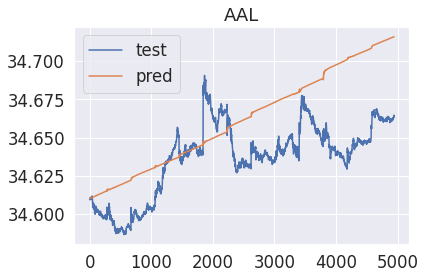

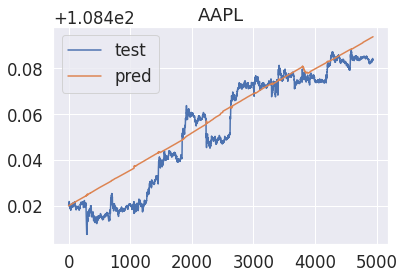

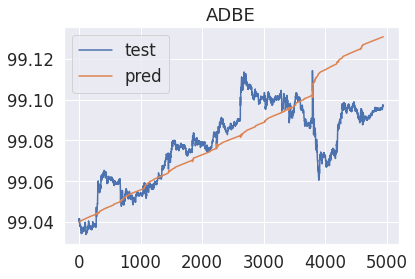

In [116]:
for i in np.arange(3):
    plt.title(df.columns[i])
    plt.plot(final_test[:, i], label='test')
    plt.plot(final_res[:, i], label='pred')
    plt.legend()
    plt.show()